# Integration into KPIC2 to implement the whole process of metabolomics processing

In [1]:
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from pyopls import OPLS
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score
import sys
sys.path.append("C:/Users/yxliao/Desktop/Smartgit3/DeepPIC/kpic2")
from permutation_vip import *
import warnings
from sys import stderr
import numpy as np
from joblib import Parallel, delayed
from sklearn.base import is_classifier, clone, ClassifierMixin
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import check_cv, cross_val_predict
from sklearn.utils import indexable, check_random_state
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np
import csv
import os
import bisect
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.rc('font',family='Calibri')

In [2]:
numpy2ri.activate()
robjects.r('''source('C:/Users/yxliao/Desktop/Smartgit3/DeepPIC/kpic2/kpic_process.R')''')
kpic_pics5 = robjects.globalenv['kpic_pics5']
PICset_decpeaks = robjects.globalenv['PICset_decpeaks']
PICset_split = robjects.globalenv['PICset_split']
PICset_getPeaks = robjects.globalenv['PICset_getPeaks']
PICset_group = robjects.globalenv['PICset_group']
PICset_align1 = robjects.globalenv['PICset_align1']
PICset_align2 = robjects.globalenv['PICset_align2']
PICset_align3 = robjects.globalenv['PICset_align3']
kpic_iso = robjects.globalenv['kpic_iso']
kpic_mat = robjects.globalenv['kpic_mat']
kpic_fill = robjects.globalenv['kpic_fill']
kpic_pattern = robjects.globalenv['kpic_pattern']

In [3]:
pics_1 = kpic_pics5()
PICS = PICset_decpeaks(pics_1)
PICS = PICset_split(PICS)
PICS = PICset_getPeaks(PICS)
groups_raw = PICset_group(PICS)
groups_align1 = PICset_align1(groups_raw)
groups_align2 = PICset_align2(groups_align1)
groups_align3 = PICset_align2(groups_align2)
groups_align = kpic_iso(groups_align3)
data = kpic_mat(groups_align)
data = kpic_fill(data)
result = kpic_pattern(data, file1 = "C:/Users/yxliao/Desktop/Smartgit3/DeepPIC/s111_example.csv")

filling peaks of D:/Dpic/data2/leaf_seed/data/1.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/2.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/3.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/4.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/5.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/6.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/7.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/8.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/9.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/10.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/11.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/12.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/13.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/14.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/15.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/16.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/17.mzXML 
filling peaks of D:/Dpic/data2/leaf_seed/data/18.mzXML 
f

# OPLS-DA scores for seed and leaf extracts

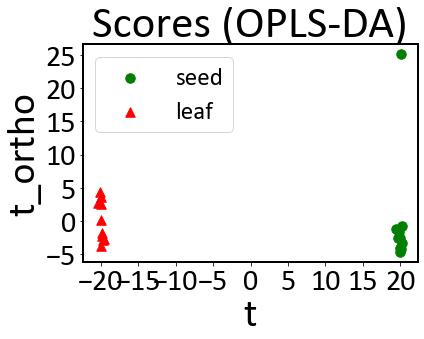

In [6]:
data = pd.read_csv("C:/Users/yxliao/Desktop/Smartgit3/DeepPIC/files/s_python.csv",encoding='gbk')
X = np.array(data.values[:,1:].T,dtype=float)
Y= np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])
opls = OPLS(1)
Z = opls.fit_transform(X, Y)
pls = PLSRegression(1)
uncorrected_r2 = r2_score(Y, pls.fit(X, Y).predict(X))
corrected_r2 = r2_score(Y, pls.fit(Z, Y).predict(Z))
uncorrected_q2 = r2_score(Y, cross_val_predict(pls, X, Y, cv=LeaveOneOut()))
corrected_q2 = r2_score(Y, cross_val_predict(pls, Z, Y, cv=LeaveOneOut()))
pls.fit_transform(Z, Y)
fig = plt.figure()
ax = fig.add_subplot(111)
bwith = 2
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
font = {'family' : 'Calibri',
'weight' : 'normal',
'size'   : 40,
    }
df = pd.DataFrame(np.column_stack([pls.x_scores_, opls.T_ortho_[:, 0]]),
                    index=Y,columns=['t', 't_ortho'])                           
pos_df = df[Y==0]
neg_df = df[Y==1]
plt.scatter(neg_df['t'], neg_df['t_ortho'], s=90, c='g', marker='o', label='seed')
plt.scatter(pos_df['t'], pos_df['t_ortho'], s=90, c='red',marker='^', label='leaf')
ax.set_title('Scores (OPLS-DA)',fontproperties = 'Calibri', size = 45)
ax.set_xlabel('t',font)
ax.set_ylabel("t_ortho",font)    
plt.yticks(fontproperties = 'Calibri', size = 30)
plt.xticks(fontproperties = 'Calibri', size = 30)
plt.legend(loc = 'upper left', prop={'family' : 'Calibri', 'size' : 25})

# Permutation test

C:\Users\yxliao\anaconda3\envs\DeepPIC\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass groups=None, cv=KFold(n_splits=5, random_state=420, shuffle=True), n_jobs=1, verbose=0, fit_params=None, pre_dispatch=2*n_jobs, method=predict as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\yxliao\anaconda3\envs\DeepPIC\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass groups=None, cv=KFold(n_splits=5, random_state=420, shuffle=True), n_jobs=None, verbose=0, fit_params=None, pre_dispatch=2*n_jobs, method=predict as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\yxliao\anaconda3\envs\DeepPIC\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass groups=None, cv=KFold(

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

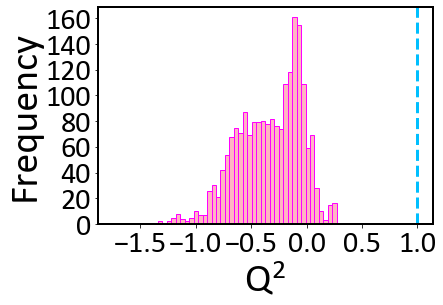

In [7]:
kf = KFold(n_splits = 5, shuffle=True, random_state=420) 
permutation_scores = permutation_test_score(pls, Z, Y, groups= None , cv=kf,
                            n_permutations=2000, n_jobs=1, random_state=420,
                            verbose=0, fit_params=None)
fig = plt.figure()
ax2 = fig.add_subplot(111)
bwith = 2
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
font = {'family' : 'Calibri',
'weight' : 'normal',
'size'   : 40,
    }
ax2.hist(permutation_scores[0][1], bins=50, density=False, fc="lightpink", ec="magenta")
ax2.axvline(permutation_scores[0][0], linewidth = 3, ls="--", color="deepskyblue")
ax2.set_xlabel('$\mathregular{Q^2}$',font)
ax2.set_ylabel("Frequency",font)    
plt.yticks(fontproperties = 'Calibri', size = 30)
plt.xticks(fontproperties = 'Calibri', size = 30)

# Selected biomarkers with VIP values greater than 1

(array([1.186, 1.187, 1.188, 1.189, 1.19 , 1.191, 1.192, 1.193]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

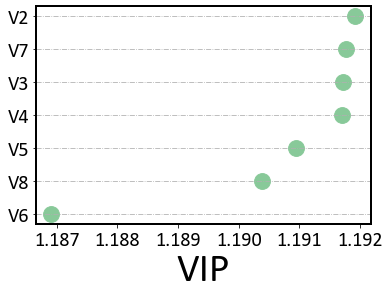

In [9]:
DATA = pd.read_csv("C:/Users/yxliao/Desktop/Smartgit3/DeepPIC/files/s_python.csv", encoding='gbk')
X = np.array(DATA.values[:,1:].T,dtype=float)
COMs = DATA.values[:,0]
VIPs = vip(Z, Y, pls)   
COM = []
VIP = []
for vv in range(11):
    if VIPs[vv]>=1: 
        VIP.append(VIPs[vv])
        COM.append(COMs[vv])
sorted_vips = sorted(enumerate(VIP), key=lambda x: x[1])
idx = [i[0] for i in sorted_vips]
vips = [i[1] for i in sorted_vips]
COMS=[]
for jj in range(len(COM)):
    COMS.append(COM[idx[jj]])
fig = plt.figure()
ax11 = fig.add_subplot(111)
bwith = 2
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
font = {'family' : 'Calibri',
'weight' : 'normal',
'size'   : 40,
    }
plt.grid(axis="y",linestyle='-.')
plt.scatter(vips,range(len(COMS)),c="#88c999",s=250,marker="o")
ax11.set_xlabel('VIP',font)
plt.yticks(range(len(COMS)),COMS,fontproperties = 'Calibri', size = 20)
plt.xticks(fontproperties = 'Calibri', size = 20)